In [2]:
library(rjags)
library(coda)

Caricamento del pacchetto richiesto: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



# Ex 1

given the following un-normalized posterior distribution:

$g(\theta \mid x) \propto \frac{1}{2} \exp[-\frac{(\theta +3)^2}{2}] + \frac{1}{2}\exp[-\frac{(\theta -3)^2}{2}]$ 

- draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

In [3]:
# posterior function 
post <- function(th){
    return (0.5 * exp(-0.5*(th+3)^2)) + (0.5 * exp(-0.5*(th-3)^2))
}  
# normalization factor       
norm_fact <- integrate(post,-99,99)$value 

# MCMC metropolis alg
metropolis <-  function(func, theta_init, n_sample, sigma){
    # init variables
    theta_cur <- theta_init
    func_curr <- func(theta_cur)
    func_samp <- matrix(data=NA, nrow=n_sample, ncol=2+1)
    
    # looping on 'candidates'
    for (n in 1:n_sample) {
        # candidate extraction 
        theta_candidate <- rnorm(n=1, mean = theta_cur, sigma)
        func_candidate <- func(theta_candidate)
        # markov ratio (if the sampling distribution is symmetric (gaussian) we can avoid it)
        Markov_ratio <- (func_candidate/func_curr)
        
        # chain step
        if(Markov_ratio > runif(1)){
            theta_cur <- theta_candidate
            func_curr <- func_candidate   
        }
        else{
            theta_cur <- theta_cur
            func_curr <- func_curr
        }
        # storing results
        func_samp[n,1] <- func_curr
        func_samp[n,2] <- theta_cur
    }
    return (func_samp)
}

In [4]:
# variables init
theta_init <- 1
sample_sig <- 5 
n_sample   <- 1000000

x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact
# building MCMC
chain <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig^2)

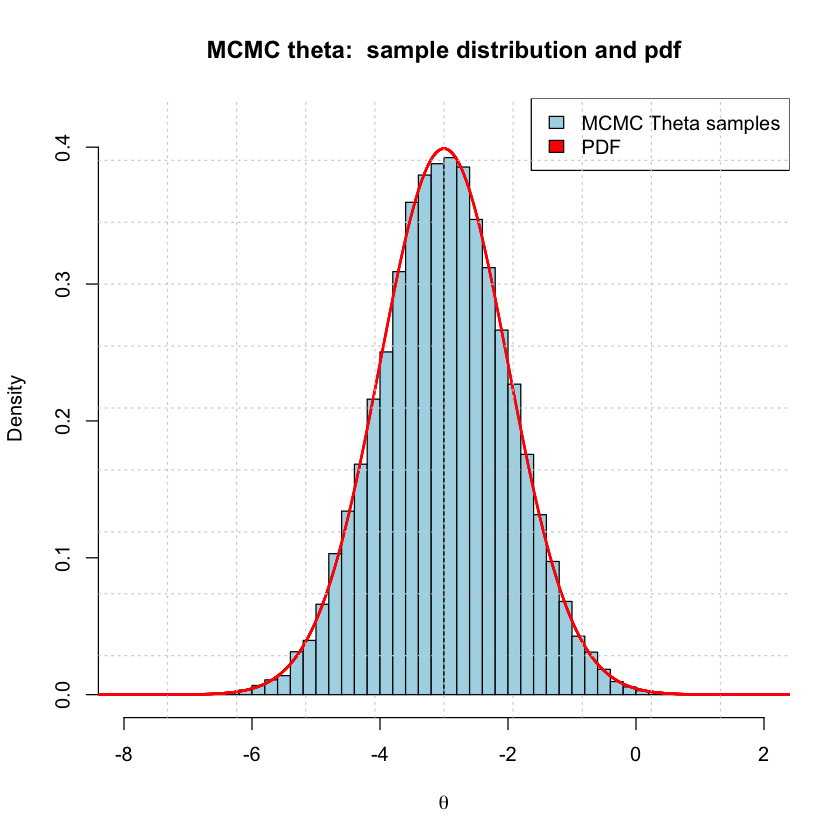

In [5]:
# plotting histogram with samples obtained from MCMC
markov_hist <- hist(chain[,2],
                    breaks = 40,
                    plot = TRUE,
                    col = 'lightblue',
                    xlab = expression(theta),
                    xlim = c(-8,2),
                    ylim = c(0, max(y)*1.05),
                    main = 'MCMC theta:  sample distribution and pdf',
                    freq = FALSE)

# superimposing normalized posterior
lines(x, y , 
      col='red',
      lwd = 2)

legend("topright", 
       legend = c("MCMC Theta samples", "PDF"),
       fill = c("lightblue", 'red'))

grid(nx = 10, ny = 10, col = "lightgray", lty = "dotted")


- use a Norm (0, 1) as random-walk candidate density

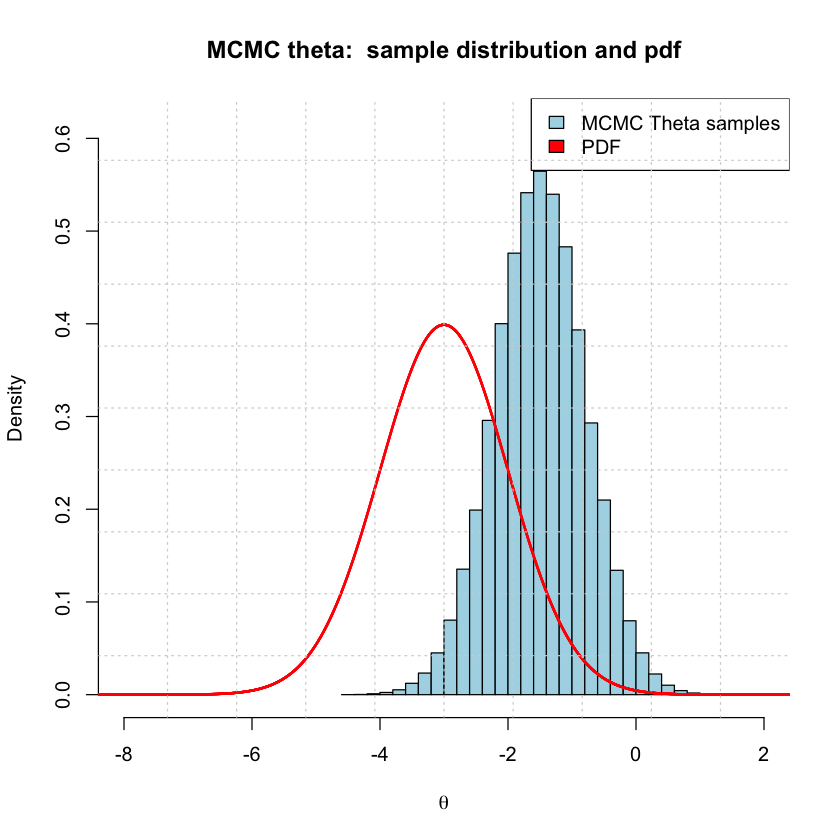

In [6]:
# now we do the same but changing the sampling distribution 

n_sample   <- 1000000
sample_sig = 1
x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact


metropolis_norm <-  function(func, theta_init, n_sample, sigma){
    theta_cur <- theta_init
    func_curr <- func(theta_cur)
    func_samp <- matrix(data=NA, nrow=n_sample, ncol=2+1)


    for (n in 1:n_sample) {
        # HERE THE CHANGE
        theta_candidate <- rnorm(n=1, mean = 0, sigma)
        func_candidate <- func(theta_candidate)
        Markov_ratio <- (func_candidate/func_curr)
        
        if(Markov_ratio > runif(1)){
            theta_cur <- theta_candidate
            func_curr <- func_candidate   
        }
        else{
            theta_cur <- theta_cur
            func_curr <- func_curr
        }

        func_samp[n,1] <- func_curr
        func_samp[n,2] <- theta_cur
    }
    return (func_samp)
}

x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact
chain <- metropolis_norm(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig^2)

#  same as before
markov_hist <- hist(chain[,2],
    breaks = 40,
    plot = TRUE,
    col = 'lightblue',
    xlab = expression(theta),
    xlim = c(-8,2),
    ylim = c(0, max(y)*1.55),
    main = 'MCMC theta:  sample distribution and pdf',
    freq = FALSE)

lines(x, y , 
      col='red',
      lwd = 2)

legend("topright", 
       legend = c("MCMC Theta samples", "PDF"),
       fill = c("lightblue", 'red'))

grid(nx = 10, ny = 10, col = "lightgray", lty = "dotted")


- plot the sampled distribution

In [7]:
# Plotted above: the shape of the sample distribution is heavly influenced by the random walk candidate distribution

- analyze the chain with the CODA package and plot the chain autocorrelation


In [8]:
# variables init
theta_init <- 1
sample_sig <- 5 
n_sample   <- 1000000

x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact
chain <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig^2)

# creating a coda chain object
mcmc_chian_obj <- mcmc(data=chain[,2])

# analyzing the chain
summary(mcmc_chian_obj)


Iterations = 1:1e+06
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+06 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
    -2.9971636      0.9931814      0.0009932      0.0054365 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
-4.960 -3.665 -2.989 -2.338 -1.062 


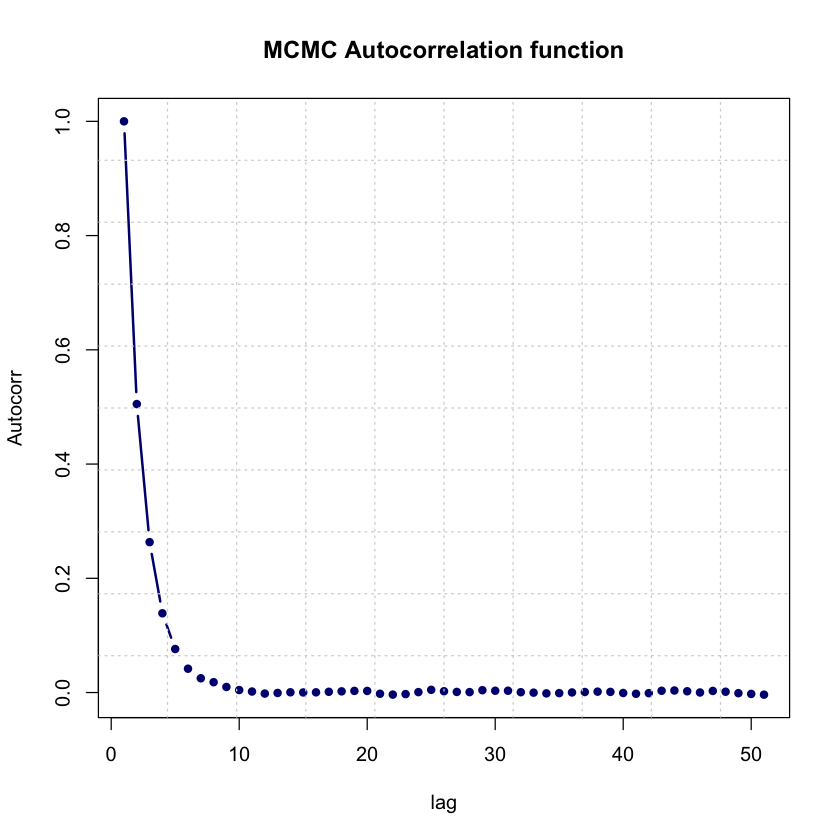

In [9]:
# autocorrelation analysis

my_lags = seq(0,500,10)
autocorr_mcmc <- autocorr(mcmc_chian_obj, lags=my_lags)
plot(autocorr_mcmc,
     col = 'navy',
     type = 'b',
     pch = 20,
     lwd = 2,
     main = 'MCMC Autocorrelation function',
     ylab = 'Autocorr',
     xlab = 'lag')
grid(nx = 10, ny = 10, col = "lightgray", lty = "dotted")

- try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?


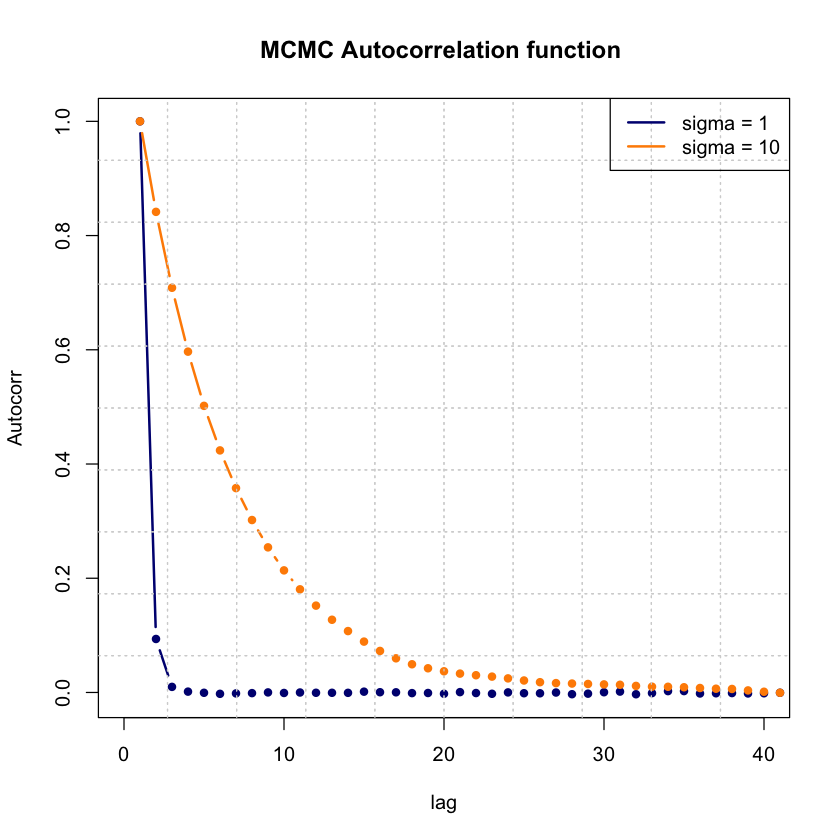

In [10]:
# autocorrelation analysis by varying the sigma of the sampling distribution

sample_sig_1 <- 1 
chain_1 <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig_1^2)
mcmc_chian_obj_1 <- mcmc(data=chain_1[,2])
autocorr_mcmc_1 <- autocorr(mcmc_chian_obj_1, lags=my_lags)

sample_sig_2 <- 10
chain_2 <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig_2^2)
mcmc_chian_obj_2 <- mcmc(data=chain_2[,2])
autocorr_mcmc_2 <- autocorr(mcmc_chian_obj_2, lags=my_lags)

plot(autocorr_mcmc_1,
     col = 'navy',
     type = 'b',
     pch = 20,
     lwd = 2,
     main = 'MCMC Autocorrelation function ',
     ylab = 'Autocorr',
     xlab = 'lag',
     xlim = c(0,40))
grid(nx = 10, ny = 10, col = "lightgray", lty = "dotted")

lines(autocorr_mcmc_2,
     col = 'dark orange',
     type = 'b',
     pch = 20,
     lwd = 2,
     ylab = 'Autocorr',
     xlab = 'lag')

grid(nx = 10, ny = 10, col = "lightgray", lty = "dotted")
legend('topright', c('sigma = 1', 'sigma = 10'), col = c('navy', 'dark orange'), lwd = 2)

# EX 2

A set of measured data should follow, according to the physics model applied to them, a linear behavior. Data are the following:


Y = [7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.32]\
X = [5, 6, 7, 8, 9, 10, 11, 12]


- perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS,assuming that data follow the model:\
$Z[i] = a + b * X[i]$

- and the likelihood of the measured data follow a Gaussian likelihood distribution:    
 $Y[i] ~dnorm(Z[i], c)$


- run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for the parameters.

In [33]:
# defining dataset
data <- NULL
data$X <- c(5, 6, 7, 8, 9, 10, 11, 12)
data$Y <- c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)

# defining parameters
inits <- NULL
inits$a <- runif(1, 1, 10)
inits$b <- runif(1, -1, 3)
inits$c <- runif(1, 0.034, 4)

# building jags model 
jm <- jags.model("linear_model.bug", data, inits)
# running the model 
update(jm, n.iter = 500000)
# building MCMC with coda from jags model
chain <- coda.samples(jm, c('a','b', 'c'),n.iter = 500000, thin = 50)
chain_df <- as.data.frame( as.mcmc(chain) )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 41

Initializing model




Iterations = 501050:1001000
Thinning interval = 50 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
a  1.47750 0.460584 4.606e-03      4.606e-03
b -0.94709 0.051694 5.169e-04      5.426e-04
c  0.04447 0.009784 9.784e-05      9.503e-05

2. Quantiles for each variable:

      2.5%      25%      50%      75%   97.5%
a  1.01107  1.14284  1.33784  1.67257  2.7177
b -0.99863 -0.98427 -0.96271 -0.92635 -0.8079
c  0.03432  0.03724  0.04164  0.04877  0.0704


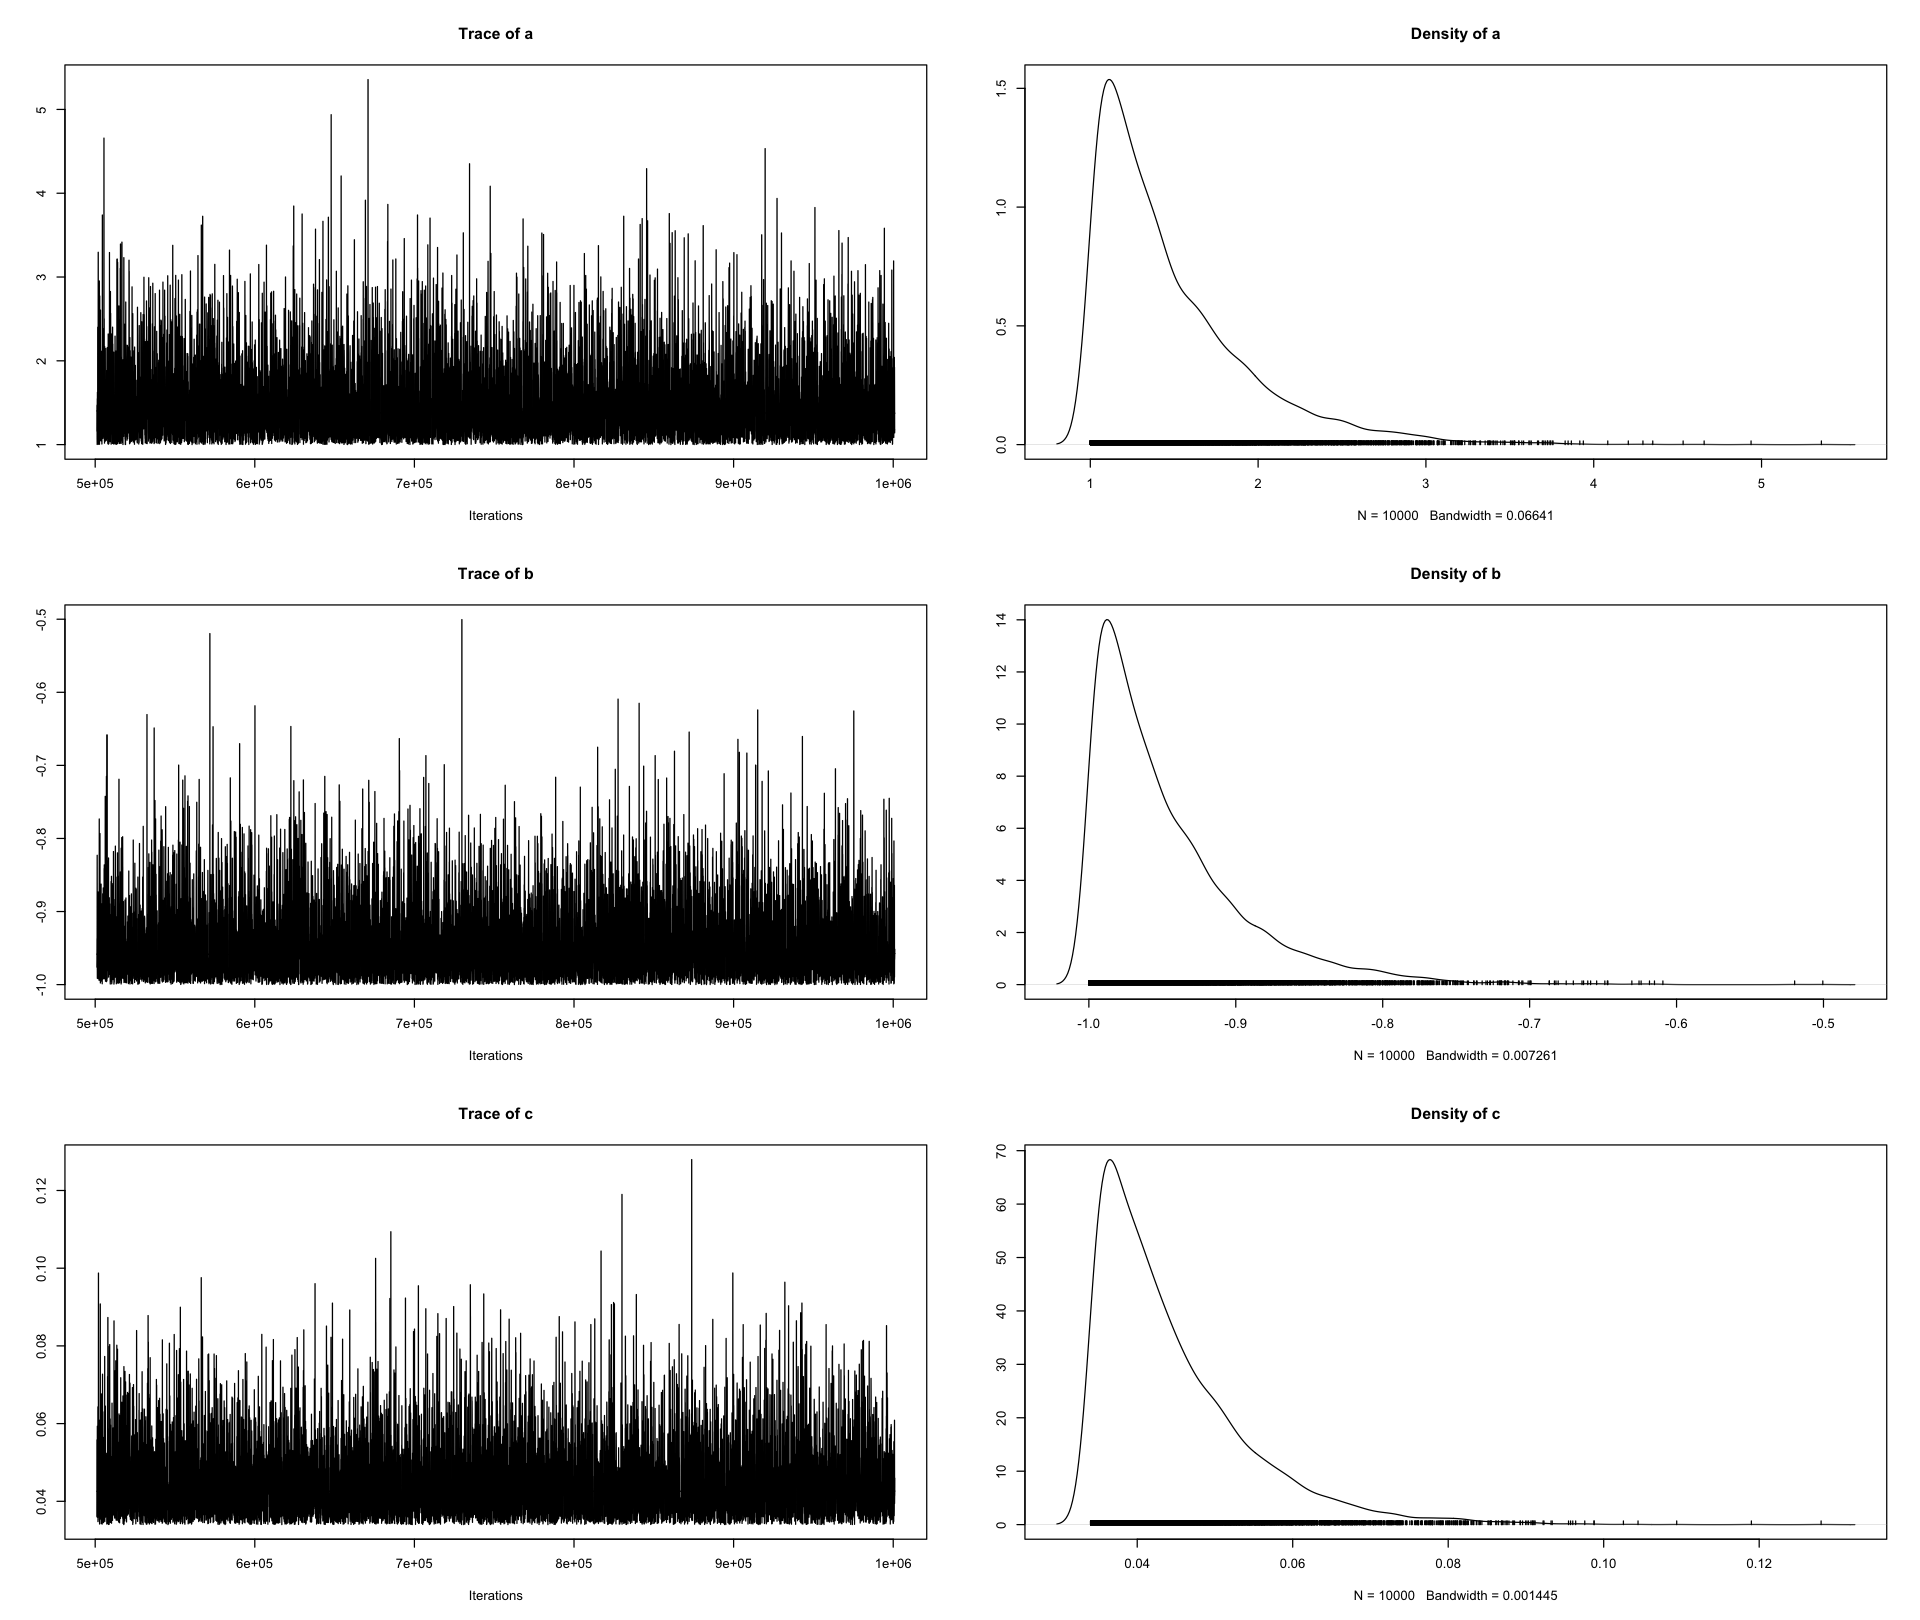

In [34]:
# chain analysis, we can see distribution and 95% credibility intervall
summary(chain)
options(repr.plot.width = 16, repr.plot.height = 13.5)
plot(chain)


- using the obtained posterior distributions, compute the posterior distribution of\
$ \sigma = \sqrt{\frac{1}{c}} $

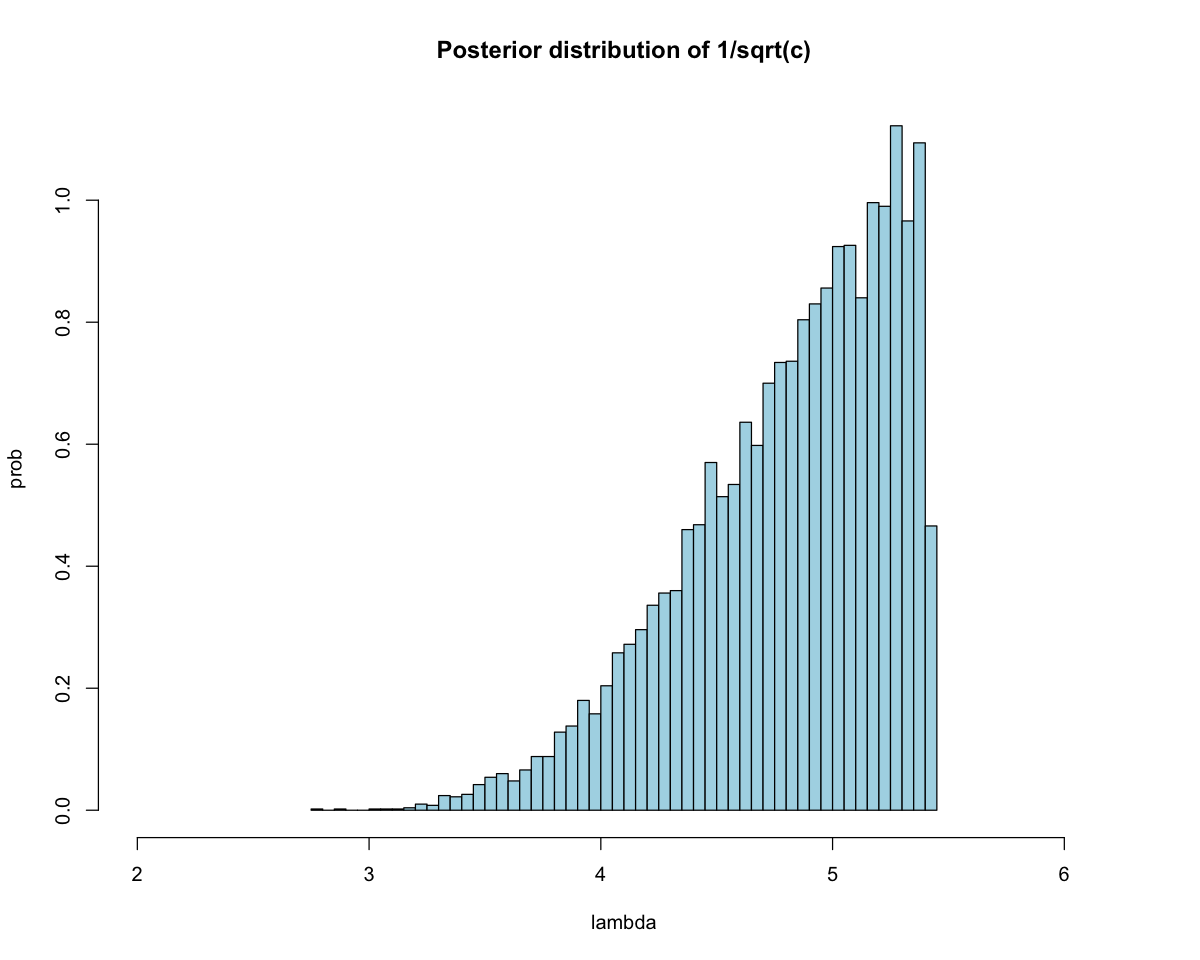

In [62]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist(1/(chain_df$c ** 0.5), nc=50, freq=FALSE, 
     col='lightblue',
     xlim=c(2, 6.2),
     xlab='lambda', 
     ylab='prob', 
     main='Posterior distribution of 1/sqrt(c)')

# EX 3

suppose we observe the following values

 - 2.06, 5.56, 7.93, 6.56, 205

and we assume that the data come from a gaussian distribution with unknown mean m and variance s2

build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribution of the mean and variance.

In [63]:
# building dataset
data <- NULL
data$X <- c(2.06, 5.56, 7.93, 6.56, 205)

# defining parameters
inits <- NULL
inits$m <- runif(1,-10, 10)
inits$s <- runif(1, 0,50)

# jags model and MCMC
n_iter = 500000
jm <- jags.model("gaussian_model.bug", data, inits)
update(jm, n.iter = n_iter)
chain <- coda.samples(jm, c('m','s'),n.iter = n_iter, thin = 50)
chain_df <- as.data.frame( as.mcmc(chain) )

Warning message in jags.model("gaussian_model.bug", data, inits):
"Unused variable "X" in data"


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 7
   Total graph size: 11

Initializing model




Iterations = 500050:1e+06
Thinning interval = 50 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean     SD Naive SE Time-series SE
m -0.0975  5.759  0.05759        0.05759
s 25.1315 14.554  0.14554        0.14554

2. Quantiles for each variable:

    2.5%    25%     50%    75%  97.5%
m -9.535 -5.048 -0.2052  4.923  9.481
s  1.219 12.429 25.1740 37.868 48.827


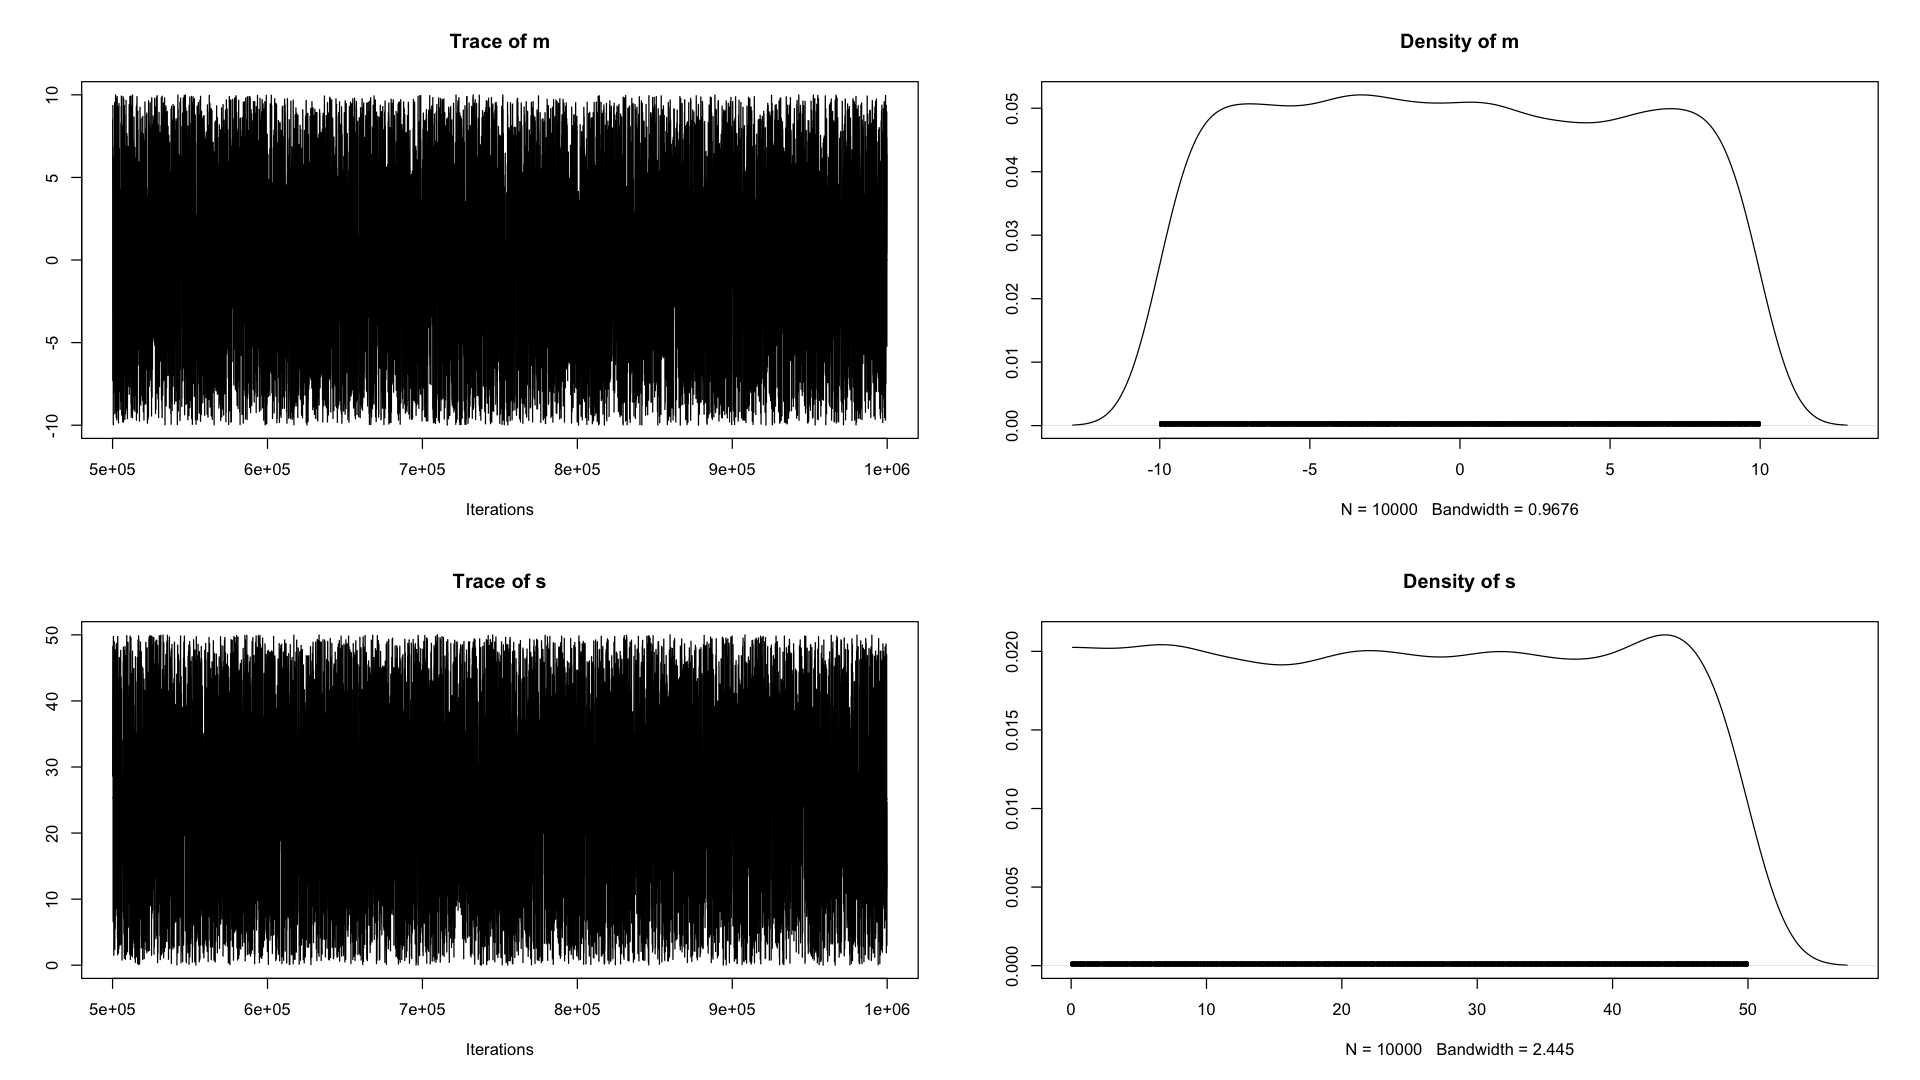

In [14]:
# chain analysis, we can see distribution and 95% credibility intervall
summary(chain)
options(repr.plot.width = 16, repr.plot.height = 9)
plot(chain)

# EX 4

The data set that Edwin Hubble ised to show that galaxies are moving either away or towards us are given in the following table:

- Using this data set define a JAGS model to fit data with the following: V[i] ~dnorm(b * D[i], c)
- where V represent the velocity in units of km/s, D is the observed distance (in units of parsec), and b and c are two parameters of the model
- assume whatever prior distribution you think is appropriate
- plot the evolution of the chains, the posterior distribution of the parameters and the 95% credibility interval

In [75]:
data <- NULL
data$V <- c(170,290,-130,-70,-185,-220,200,290,270,200,290,450,500,500,960,500,850,800,1090)
data$D <- c(0.0032,0.0034,0.214,0.263,0.275,0.275,0.45,0.5,0.5,0.63,0.8,0.9,0.9,0.9,0.9,2,2,2,2)

# we used a uniform prior 
inits <- NULL
inits$b <- runif(1,0, 1000)
inits$c <- dunif(1,0, 1)

jm <- jags.model("Hubble_model.bug ", data, inits)
n_iter <- 1000000
update(jm, n.iter = n_iter)
chain <- coda.samples(jm, c('b','c'),n.iter = n_iter, thin = 50)
chain_df <- as.data.frame( as.mcmc(chain) )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 54

Initializing model




Iterations = 1001050:2001000
Thinning interval = 50 
Number of chains = 1 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
b 3.543e+02 8.751e+01 6.188e-01      6.188e-01
c 7.860e-06 2.502e-06 1.769e-08      1.765e-08

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
b 1.821e+02 2.978e+02 3.545e+02 4.112e+02 5.280e+02
c 3.760e-06 6.065e-06 7.596e-06 9.356e-06 1.349e-05


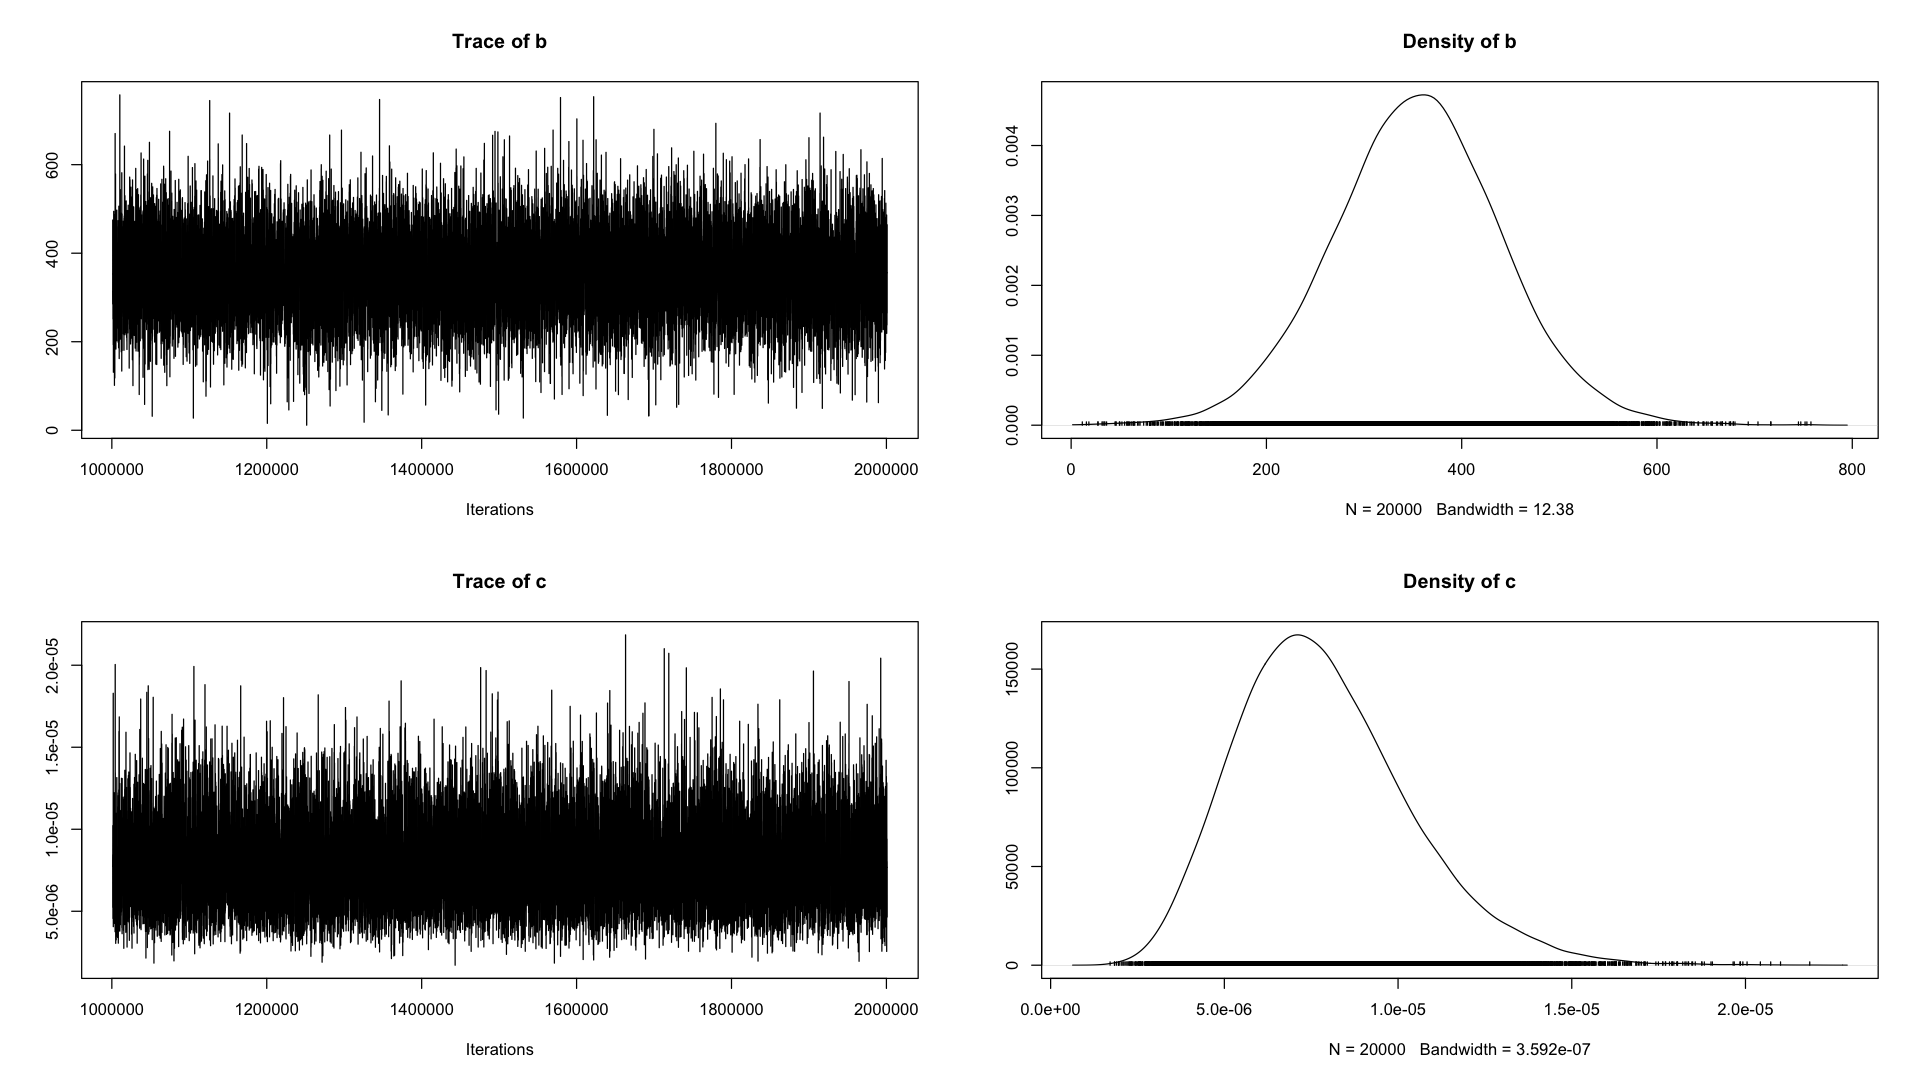

In [76]:
summary(chain)
options(repr.plot.width = 16, repr.plot.height = 9)
plot(chain)